In [1]:
!conda activate dangson

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as f
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
class CustomDataset(Dataset):
    def __init__(self, link):
        self.link = link
        self.item = os.listdir(self.link+'images/')

    def __getitem__(self, idx):
        x = cv2.imread(self.link+'images/'+self.item[idx], flags=cv2.IMREAD_GRAYSCALE)/255
        y = cv2.imread(self.link+'infection masks/'+self.item[idx], flags=cv2.IMREAD_GRAYSCALE)
        x = torch.FloatTensor(x).unsqueeze(dim=0)
        mask = np.zeros((260,260))
        mask[2:-2, 2:-2] = y
        mask = (mask/255).astype(int)
        mask = torch.FloatTensor(mask).unsqueeze(dim=0)
        
        return x, mask

    def __len__(self):
        return len(self.item)

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inblock1 = nn.Sequential(
            nn.Conv2d(1, 64, 3,padding=(94, 94)),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.inblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU()
        )
        self.inblock3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
        )
        self.inblock4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
        )

        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, 3),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 2, 2)
        )

        self.outblock4 = nn.Sequential(
            nn.Conv2d(1024, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, 2)
        )
        self.outblock3 = nn.Sequential(
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2)
        )
        self.outblock2 = nn.Sequential(
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2)
        )
        self.outblock1 = nn.Sequential(
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 2, 1),
            nn.Conv2d(2, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        in1 = self.inblock1(data)
        in2 = self.inblock2(in1)
        in3 = self.inblock3(in2)
        in4 = self.inblock4(in3)

        out4 = self.bottleneck(in4)
        x4, y4 = out4.shape[-2], out4.shape[-1]
        out4 = torch.cat([in4[:,:,in4.shape[-2]//2-x4//2:in4.shape[-2]//2-x4//2+x4, in4.shape[-1]//2-y4//2:in4.shape[-1]//2-y4//2+y4], out4], dim=1)

        out3 = self.outblock4(out4)
        x3, y3 = out3.shape[-2], out3.shape[-1]
        out3 = torch.cat([in3[:,:,in3.shape[-2]//2-x3//2:in3.shape[-2]//2-x3//2+x3, in3.shape[-1]//2-y3//2:in3.shape[-1]//2-y3//2+y3], out3], dim=1)

        out2 = self.outblock3(out3)
        x2, y2 = out2.shape[-2], out2.shape[-1]
        out2 = torch.cat([in2[:,:,in2.shape[-2]//2-x2//2:in2.shape[-2]//2-x2//2+x2, in2.shape[-1]//2-y2//2:in2.shape[-1]//2-y2//2+y2], out2], dim=1)

        out1 = self.outblock2(out2)
        x1, y1 = out1.shape[-2], out1.shape[-1]
        out1 = torch.cat([in1[:,:,in1.shape[-2]//2-x1//2:in1.shape[-2]//2-x1//2+x1, in1.shape[-1]//2-y1//2:in1.shape[-1]//2-y1//2+y1], out1], dim=1)

        output = self.outblock1(out1)
        return output

In [5]:
trainset = CustomDataset('data/Train/COVID-19/')
validset = CustomDataset('data/Val/COVID-19/')
train_loader = DataLoader(trainset, batch_size=20, shuffle=True, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=20, shuffle=True, pin_memory=True)

In [6]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# device = 'cuda'
# model = UNet().to(device)
# # model.load_state_dict(torch.load("state/model_e90.pth"))

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# loss_fn = torch.nn.BCELoss()

# E = 101
# train_loss_hist = []
# valid_loss_hist = []
# # train_loss_hist = np.load("train_loss_hist.npy")[:91].tolist()
# # valid_loss_hist = np.load("valid_loss_hist.npy")[:91].tolist()

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = 'cuda'
model = UNet().to(device)
model.load_state_dict(torch.load("state/model_e40.pth"))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()
E = 101
train_loss_hist = []
valid_loss_hist = []
train_loss_hist = np.load("train_loss_hist.npy")[:41].tolist()
valid_loss_hist = np.load("valid_loss_hist.npy")[:41].tolist()

In [8]:
for e in range(41,E):
    train_loss = 0
    # train_acc = 0
    model.train()
    for x, y  in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # train_acc += (np.sum(np.array(output.argmax(dim=1).tolist()) == np.array(y.tolist())))/23000
    train_loss /= len(train_loader)
    train_loss_hist.append(train_loss)
    if e%10==0:
        torch.save(model.state_dict(), "state/model_e"+str(e)+".pth")
#     print(e, ": ", total_loss) 
    


    valid_loss = 0 
    # valid_acc = 0
    with torch.inference_mode():
        for x,y in tqdm(valid_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = loss_fn(output, y)
            valid_loss += loss.item()
    # 		valid_acc += (np.sum(np.array(target.argmax(dim=1).tolist()) == np.array(y.tolist())))/2000
    valid_loss /= len(valid_loader)
    valid_loss_hist.append(valid_loss)

    print(e, ": " , train_loss, ", ", valid_loss)
    
    trainhist = np.array(train_loss_hist)
    validhist = np.array(valid_loss_hist)
    np.save("train_loss_hist.npy", trainhist)
    np.save("valid_loss_hist.npy", validhist)
    # print(e , ": " , total_loss, ", ", train_acc,", ",valid_loss,", ", valid_acc)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

41 :  0.04298417876534005 ,  0.18404578355451426


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

42 :  0.036338817724522125 ,  0.2024892084300518


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

43 :  0.034054321276539186 ,  0.18925929752488932


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

44 :  0.03436368652322191 ,  0.2045187009498477


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

45 :  0.03492670343752871 ,  0.21824434554825226


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

46 :  0.033355475958198946 ,  0.21474693156778812


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

47 :  0.031374505859740234 ,  0.21236420391748348


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

48 :  0.03038556957022941 ,  0.2331295677771171


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

49 :  0.02979368405376977 ,  0.2610432766377926


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

50 :  0.02909663618799854 ,  0.18079119610289732


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

51 :  0.028287214841297332 ,  0.23656920778254667


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

52 :  0.026976657952082917 ,  0.2216064582268397


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

53 :  0.025656772638730545 ,  0.24417609721422195


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

54 :  0.024395511346928616 ,  0.2816670121004184


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

55 :  0.027697729719604585 ,  0.25894566904753447


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

56 :  0.024950711829389665 ,  0.25944287950793904


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

57 :  0.023666119539832817 ,  0.26879995067914325


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

58 :  0.023293306159370756 ,  0.2847892300536235


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

59 :  0.02302203303638925 ,  0.275945491467913


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

60 :  0.02291033763755509 ,  0.30356795402864617


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

61 :  0.019730885552757597 ,  0.31841047294437885


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

62 :  0.019231620086158845 ,  0.2958016935735941


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

63 :  0.018934428483802588 ,  0.3285430104782184


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

64 :  0.018016814006532125 ,  0.3369475280245145


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

65 :  0.017653466856226006 ,  0.371036392947038


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

66 :  0.01664359268157723 ,  0.3470248623440663


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

67 :  0.016530600376427174 ,  0.398011922215422


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

68 :  0.015860260454343356 ,  0.3877835677315791


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

69 :  0.015596307952828865 ,  0.44565437858303386


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

70 :  0.01591624652451657 ,  0.4071495557824771


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

71 :  0.015532786026597023 ,  0.3768753545979659


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

72 :  0.016400696640398275 ,  0.37061511476834613


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

73 :  0.01577655078367667 ,  0.38386717066168785


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

74 :  0.014960902782672264 ,  0.37748598741988343


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

75 :  0.01463336364782237 ,  0.3800824886808793


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

76 :  0.013882682955962546 ,  0.42624968973298866


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

77 :  0.013333583072303458 ,  0.42575905409952003


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

78 :  0.014570566340092015 ,  0.39545066220064956


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

79 :  0.014261636565974418 ,  0.42270391806960106


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

80 :  0.013017469987352478 ,  0.4579846188426018


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

81 :  0.012947870081568018 ,  0.4428328952441613


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

82 :  0.013305170501166202 ,  0.2984435757001241


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

83 :  0.013379886736498868 ,  0.4421641454100609


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

84 :  0.014384169339578836 ,  0.33047441951930523


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

85 :  0.014233784373611846 ,  0.4489765452841918


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

86 :  0.012935503970514586 ,  0.44268595799803734


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

87 :  0.012275272653378706 ,  0.4052744545042515


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

88 :  0.012556522569440782 ,  0.4882420419404904


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

89 :  0.01202944590848811 ,  0.36229283548891544


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

90 :  0.012109763732061107 ,  0.41120716743171215


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

91 :  0.011979322920137264 ,  0.4289599011341731


  0%|          | 0/94 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
image, ano = validset[1000]
imagein = image.unsqueeze(dim=1).to(device)
model = UNet().to('cuda')

IndexError: list index out of range

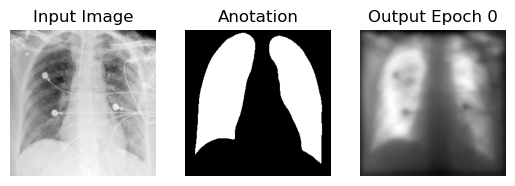

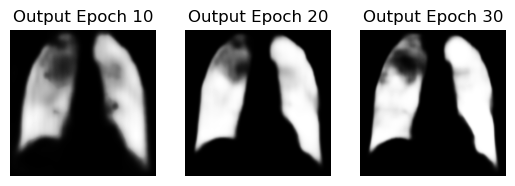

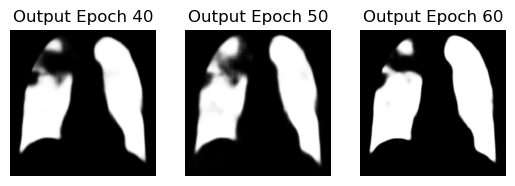

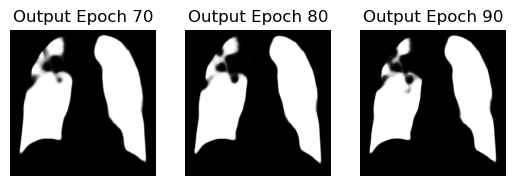

In [21]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(image[0], 'gray')
ax[0].set_title("Input Image")
ax[1].imshow(ano[0], 'gray')
ax[0].axis('off')
ax[1].axis('off')
ax[1].set_title("Anotation")
for i in range(1):
    model.load_state_dict(torch.load('state/model_e'+str(i*10)+'.pth'))
    ax[i+2].imshow(model(imagein).detach().cpu()[0][0], 'gray')
    ax[i+2].axis('off')
    ax[i+2].set_title("Output Epoch "+str(i*10))
plt.show()

fig, ax = plt.subplots(1,3)
for i in range(1, 4):
    model.load_state_dict(torch.load('state/model_e'+str(i*10)+'.pth'))
    ax[i-1].imshow(model(imagein).detach().cpu()[0][0], 'gray')
    ax[i-1].axis('off')
    ax[i-1].set_title("Output Epoch "+str(i*10))
plt.show()

fig, ax = plt.subplots(1,3)
for i in range(4, 7):
    model.load_state_dict(torch.load('state/model_e'+str(i*10)+'.pth'))
    ax[i-4].imshow(model(imagein).detach().cpu()[0][0], 'gray')
    ax[i-4].axis('off')
    ax[i-4].set_title("Output Epoch "+str(i*10))
plt.show()

fig, ax = plt.subplots(1,3)
for i in range(7, 10):
    model.load_state_dict(torch.load('state/model_e'+str(i*10)+'.pth'))
    ax[i-7].imshow(model(imagein).detach().cpu()[0][0], 'gray')
    ax[i-7].axis('off')
    ax[i-7].set_title("Output Epoch "+str(i*10))
plt.show()

# model.load_state_dict(torch.load('state/model_e100.pth'))
# plt.imshow(model(imagein).detach().cpu()[0][0],'gray')
# plt.axis('off')
# plt.title("Output Epoch 100")
# plt.show()

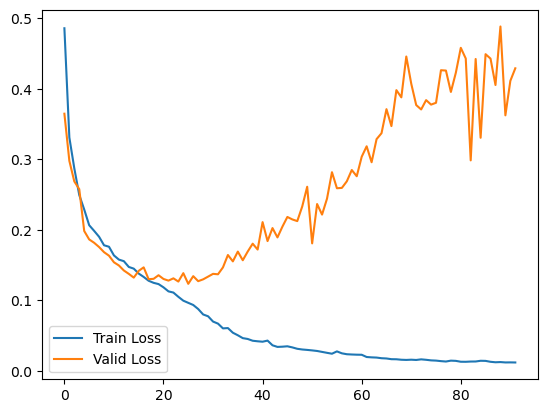

In [13]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(valid_loss_hist, label="Valid Loss")
plt.legend()
plt.show()
